In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

When we take an image using pin-hole camera, we loose an important information, ie depth of the image. Or how far is each point in the image from the camera because it is a 3D-to-2D conversion. So it is an important question whether we can find the depth information using these cameras. To achieve this we can use more than one camera. Our eyes works in similar way where we use two cameras (two eyes) which is called stereo vision.

Read [this](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html#epipolar-geometry) for more information.

To find, epipolar lines and epiples we need <b>Fundamental Matrix (F)</b> and <b>Essential Matrix (E)</b>.

<b>Essential Matrix (E)</b> contains the information about translation and rotation, which describe the location of the second camera relative to the first in global coordinates.

But we prefer measurements to be done in pixel coordinates. <b>Fundamental Matrix (F)</b> contains the same information as Essential Matrix in addition to the information about the intrinsics of both cameras so that we can relate the two cameras in pixel coordinates. Fundamental Matrix F, maps a point in one image to a line (epiline) in the other image. This is calculated from matching points from both the images. A minimum of 8 such points are required to find the fundamental matrix (while using 8-point algorithm). More points are preferred and use RANSAC to get a more robust result.

#### Finding Fundamental Matrix

In [5]:
# Using SIFt descriptors with FLANN based matcher and ratio test

img1 = cv2.imread('images/left_image.png', 0)
img2 = cv2.imread('images/right_image.png', 0)

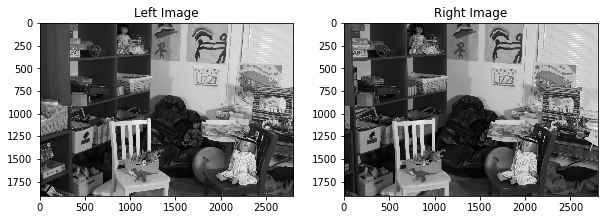

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img1, 'gray')
plt.title('Left Image')
plt.subplot(122)
plt.imshow(img2, 'gray')
plt.title('Right Image')

In [17]:
sift = cv2.xfeatures2d.SIFT_create()

# find keypoints and descriptrs with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN PARAMETERS
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
pts1 = []
pts2 = []


for i, (m, n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)

# Selecting only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

#### Finding Epipolar Lines

Epilines corresponding to the points in first image is drawn on second image. We get an array of lines. So we define a new function to draw these lines on the images.

In [39]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 8, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 8, color, -1)
    return img1, img2

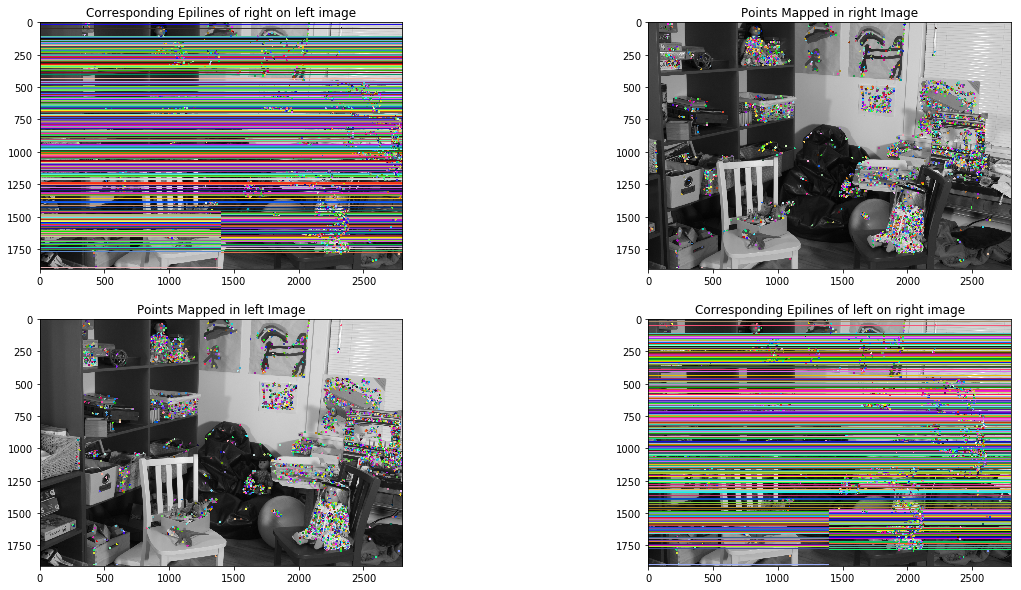

In [41]:
# Find epilines corresponding to points in right image(second image) and drawing its lines on left image

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(20, 10))
plt.subplot(221), plt.imshow(img5), plt.title(
    'Corresponding Epilines of right on left image')
plt.subplot(222), plt.imshow(img6), plt.title('Points Mapped in right Image')

plt.subplot(223), plt.imshow(img4), plt.title('Points Mapped in left Image')
plt.subplot(224), plt.imshow(img3), plt.title(
    'Corresponding Epilines of left on right image')

plt.show()